In [20]:
# %pip install diffrax --quiet
import diffrax
print(f"diffrax version={diffrax.__version__}")
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

diffrax version=0.5.0


# Toy problem

Solve Langevin SDE:
$$dX = \frac 1 2 \nabla_X \log \mathcal N(X\mid 0,1)dt  + dB= -\frac 1 2 Xdt + dB$$

In [5]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, UnsafeBrownianPath
from jax import eval_shape

class get_control():
    def __init__(self, contr, y_shape):
        self.contr = contr
        self.y_shape = y_shape
    def evaluate(self, t0, t1):
        return self.contr(t0, t1)*jnp.ones(self.y_shape)
    def __call__(self, t0, t1):
        return self.evaluate(t0, t1)

# Let's make the time control $dt$ multidimensional
shape = (2,2)
termsODE = ODETerm(lambda x:x)
control = get_control(termsODE.contr, shape)
terms = ControlTerm(termsODE.vector_field, control)
vf_val = jnp.ones(shape)
contr_val = terms.contr(t0=0,t1=2)
print(f"Now vector field value is=\n{vf_val},\n and control value is=\n{contr_val}.\n")
print(f"Then term product returns=\n{terms.prod(vf_val, contr_val)}")
print(f"""while it "should" return=\n{vf_val * contr_val}.""")

Now vector field value is=
[[1. 1.]
 [1. 1.]],
 and control value is=
[[2. 2.]
 [2. 2.]].

Then term product returns=
[[2. 2.]
 [2. 2.]]
while it "should" return=
[[2. 2.]
 [2. 2.]].


The way it is implemented is: $dX = f \odot dt + g \cdot dB$, where $\odot$ is piecewise product and $\cdot$ is matrix product.

In [3]:
brownian_motion = VirtualBrownianTree(0, 1, tol=0.01, shape=(2,3), key=random.PRNGKey(0))
brownian_motion.evaluate(0.1,.2) # check if brownian control has right shape and values

Array([[-0.25489005,  0.31733644,  0.20628473],
       [ 0.09569101, -0.27133298,  0.02177736]], dtype=float32)

In [3]:
n_steps, dt = 100, 1e-1
t0, t1 = 0., n_steps*dt
drift = lambda t, y, args: -y/2
# drift = lambda t, y, args: jnp.zeros_like(y)
# diffusion = lambda t, y, args: jnp.ones_like(y)
diffusion = lambda t, y, args: jnp.zeros_like(y)
solver = Euler()
saveat = SaveAt(steps=True)
# saveat = SaveAt(dense=True)


def diffrax_langevin(y, seed):
    # y_shape = eval_shape(lambda x: x, y)
    y_shape = y.shape
    print(f"{y_shape=}")
    # brownian_motion = VirtualBrownianTree(t0, t1, tol=dt/10, shape=y_shape, key=seed)
    # terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
    # terms = ControlTerm(diffusion, brownian_motion)

    termsODE = ODETerm(drift)
    control = get_control(termsODE.contr, y_shape)
    terms = ControlTerm(termsODE.vector_field, control)
    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt, y0=y, max_steps=n_steps+1, saveat=saveat)
    return sol.ys[:n_steps]
    # return vmap(sol.evaluate)(np.linspace(t0,t1, n_steps))

def my_langevin(y, seed):
    current = y
    meshes = [current]
    brown = random.normal(seed, (n_steps,*y.shape))
    for i in range(n_steps-1):
        current = current + drift(None, current, None)*dt + diffusion(None, current, None) * brown[i]*dt**.5
        meshes.append(current)
    return np.array(meshes)

In [4]:
shape = (6,1)
init = random.normal(random.PRNGKey(1), shape)
meshes1 = diffrax_langevin(init, random.PRNGKey(0))
meshes2 = my_langevin(init, random.PRNGKey(0))
meshes1.shape, meshes2.shape

y_shape=(6, 1)


((100, 6, 1), (100, 6, 1))

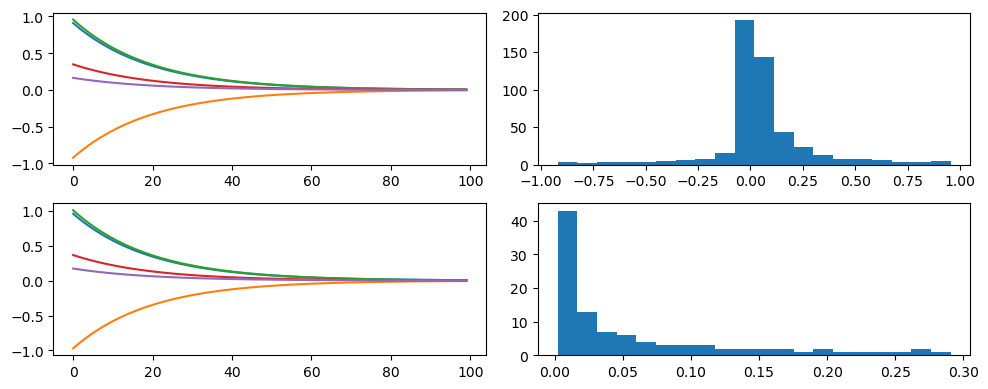

In [5]:
n_toplot = 5
plt.figure(figsize=(10,4))
plt.subplot(221)
plt.plot(meshes1[:,:n_toplot,0])
plt.subplot(222)
plt.hist(meshes1[:,:n_toplot,0].reshape(-1), bins=20)
plt.subplot(223)
plt.plot(meshes2[:,:n_toplot,0])
plt.subplot(224)
plt.hist(meshes2[:,n_toplot,0].reshape(-1), bins=20)
plt.tight_layout(), plt.show();

In [22]:
from matplotlib import animation, rc
rc('animation', html='html5')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
vmax = 2
quad1 = plt.pcolormesh(meshes1[0], vmin=-10*vmax, vmax=10*vmax)
plt.title("diffrax langevin")
plt.colorbar()
plt.subplot(1,2,2)
quad2 = plt.pcolormesh(meshes2[0], vmin=-vmax, vmax=vmax)
plt.title("my langevin")
plt.colorbar()
plt.tight_layout()

def update(i):
    quad1.set_array(meshes1[i])
    quad2.set_array(meshes2[i])

anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes1), interval=100)
plt.close(), display(anim);

# Which operation to use for control term product?

Specification:
* Should be able to perform both piecewise and matrix product.
* Without extra computational cost.
* Preferably without reshaping arrays.

In [71]:
def diffrax_prod(a, b):
    return jnp.tensordot(a, b, jnp.ndim(b))

a = jr.randint(jr.PRNGKey(0), (2,2), minval=0, maxval=5)
b = jr.randint(jr.PRNGKey(0), (2,2), minval=0, maxval=5)
print(f"piecewise=\n{a*b},")
print(f"\nmatrix=\n{a@b}.\n")
c = a[:,:,None]
d = b[:,None]
print(f"{c.shape=}, {d.shape=}")

# jnp.matmul(c, d).shape
# jnp.dot(c, d).shape

c = a[:,:,None]
d = b[None]
print(f"{c.shape=}, {d.shape=}")
jnp.einsum('...k,k...->...', c, d)

piecewise=
[[9 1]
 [4 0]],

matrix=
[[11  3]
 [ 6  2]].

c.shape=(2, 2, 1), d.shape=(2, 1, 2)
c.shape=(2, 2, 1), d.shape=(1, 2, 2)


Array([[9, 1],
       [4, 0]], dtype=int32)